# pytorch

In [ ]:
import urllib
url, filename = ("https://media.bunjang.co.kr/product/221232138_{cnt}_1681566135_w{res}.jpg", "shirts.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [ ]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

pajama 0.7874180674552917
apron 0.10574471205472946
swimming trunks 0.020261457189917564
bow tie 0.016007767990231514
sweatshirt 0.01297826785594225


# pytorch transfer learning1

In [ ]:
# -- torch._six 에러 생기면 최신 버전으로 업데이트 해주기 --
# !pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html -U

In [ ]:
# # 개와 고양이 데이터 세트 다운로드
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [ ]:
# 실습에 필요한 라이브러리 불러오기
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# other
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [ ]:
batch_size=200
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
# 데이터 가져오기
trainset = datasets.CIFAR10(root='dataset/',train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='dataset/',train=False,
                                       download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 79356803.65it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


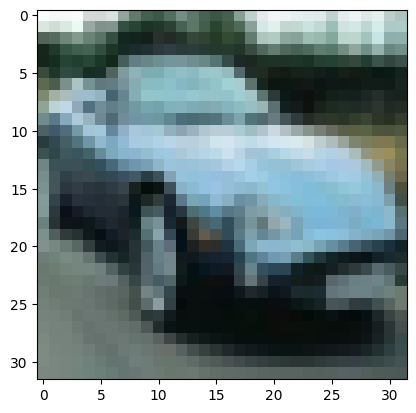

car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

test = iter(trainloader)
images, labels = next(test)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# imshow(torchvision.utils.make_grid(images))
imshow(images[0])
print(classes[labels[0]])

In [ ]:
# 학습 세트에 적용할 데이터 변환을 설정
# 데이터 전처리
train_config = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# 테스트 세트에 적용할 데이터 변환을 설정
test_config = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [ ]:
# 모델의 가중치를 더 이상 학습하지 않도록 설정.
# 가중치는 require_grad라는 속성 값을 가지고 있는데 이 값을 False로 설정하면 모델 학습시 이 가중치는 학습하지 않음.
# for param in model.features.parameters():
#     param.require_grad = False

In [ ]:
# 출력층을 1개의 노드를 가진 전결합층으로 교체

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(classes))



## 모델의 연산을 그래픽 카드에서 하도록 설정
print(model.to('cuda'))

In [ ]:
# model 클래스 개수
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# Training
def train(epoch, model, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss/total
    epoch_acc = correct/total*100
    print("Train | Loss:%.4f Acc: %.2f%% (%s/%s)"
        % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

def test(epoch, model, criterion, optimizer):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()*inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = test_loss/total
        epoch_acc = correct/total*100
        print("Test | Loss:%.4f Acc: %.2f%% (%s/%s)"
            % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [ ]:
import time
start_time = time.time()
best_acc = 0
epoch_length = 100
save_loss = {"train":[],
             "test":[]}
save_acc = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, model, criterion, optimizer)
    save_loss['train'].append(train_loss)
    save_acc['train'].append(train_acc)

    test_loss, test_acc = test(epoch, model, criterion, optimizer)
    save_loss['test'].append(test_loss)
    save_acc['test'].append(test_acc)

    scheduler.step()

    # Save model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

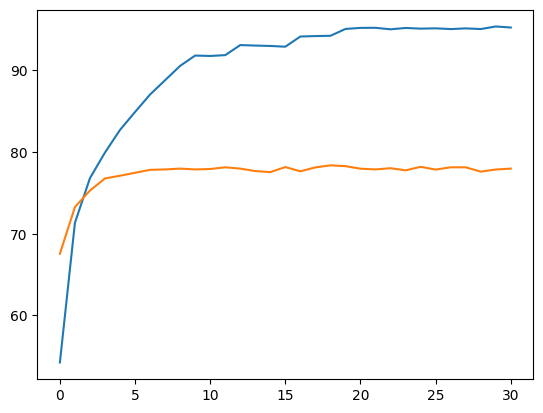

In [ ]:
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])

# tensorflow

In [ ]:
import urllib
url, filename = ("https://media.bunjang.co.kr/product/223315919_1_1685307631_w{res}.jpg", "coat.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image
from tensorflow.image import resize, decode_image
import tensorflow as tf
from PIL import Image

model = MobileNetV2(weights='imagenet')

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

image_raw = tf.io.read_file(filename)
image = decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

1/1 [==============================] - 2s 2s/step


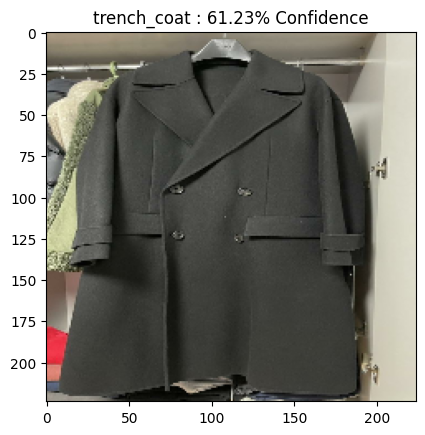

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()